<a href="https://colab.research.google.com/github/Jhonatanup/Stock-Market-Analysis/blob/master/TCC_StockPred_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt

from keras.models import load_model

from google.colab import files
uploaded = files.upload()

import io

Saving VALE3.SA.csv to VALE3.SA.csv


## Prediction of Closing Price of Stock LSTM
The goal is to predict the Closing Price behavior of a single company by predicting `n` coming days (`forward_days`), using as input the `m` past days (`look_back`).

### (Prevendo o preço de uma ação no mercado de ações)

O objetivo é prever o que acontecerá com o valor de fechamento de uma ação em `n` dias (`forward_days`), tendo como base os `m` dias anteriores (`look_back`).

In [0]:
look_back = 40
forward_days = 10
num_periods = 20

First, just open the CSV using Pandas, set the `Date` as index and keep only the Closing Price column.

Primeiro, vamos abrir o CSV com o Pandas, colocar as datas como index e manter apenas a coluna que queremos prever, que é o preço de fechamento.

In [0]:
#open the csv, chose company_N, where N = {A, B, C or D}
df = pd.read_csv(io.BytesIO(uploaded['VALE3.SA.csv']))
#set date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#keep only the 'Close' column
df = df['Close']

df.head()

Date
2014-05-19    29.469999
2014-05-20    28.860001
2014-05-21    28.889999
2014-05-22    29.340000
2014-05-23    29.260000
Name: Close, dtype: float64

In [0]:
len(df)

1244

### Data visualization  ( Vizualizando os dados )

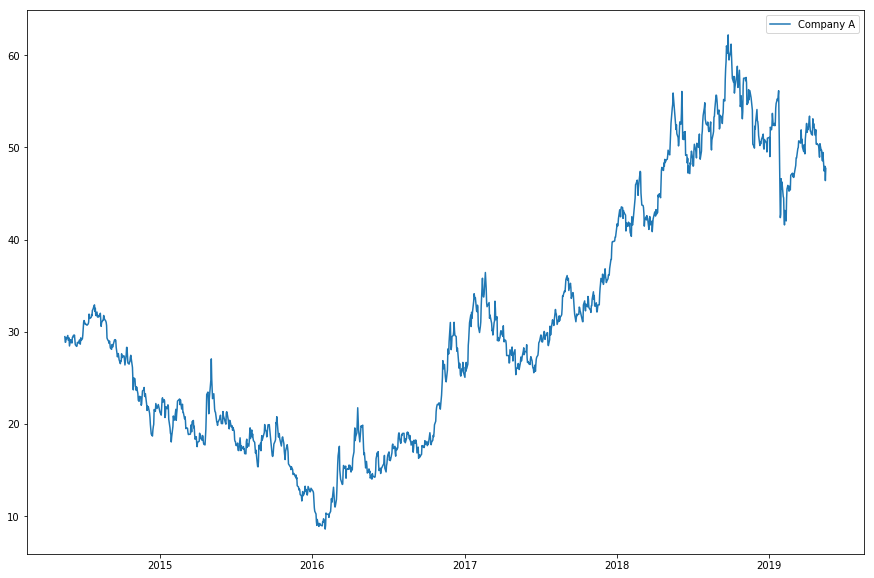

In [0]:
plt.figure(figsize = (15,10))
plt.plot(df, label='Company A')
plt.legend(loc='best')
plt.show()

### Data normalization  ( Normalizando os dados )

In [0]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[29.469999],
       [28.860001],
       [28.889999],
       [29.34    ],
       [29.26    ]])

In [0]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.38936565],
       [0.37798509],
       [0.37854475],
       [0.38694029],
       [0.38544775]])

### Split the data in Data to Train/Validate the LSTM and Data to Test the model

The Test set will be the last `k` (`num_periods`) periods we want test the model. In each period, the model will predict the next `n` coming days. The remaning data will be used for Train/Validation.

### ( Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste)
Vamos separar para os últimos `k` períodos (`num_periods`) para testar o modelo. A cada período, o modelo irá prever os próximos `n` dias. O resto será utilizado para o treinamento (Treino e Validação).

In [0]:
#split in Train and Test

division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [0]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [0]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(796, 40, 1)
(199, 40, 1)
(20, 40, 1)
(796, 10)
(199, 10)
(20, 10)


## Training the LSTM (Treinando a LSTM)

In [0]:
#NUM_NEURONS_FirstLayer = 50
#NUM_NEURONS_SecondLayer = 30
#EPOCHS = 50

#Build the model#
#model = Sequential()
#model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
#model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
#model.add(Dense(forward_days))
#model.compile(loss='mean_squared_error', optimizer='adam')

#history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)
#NUM_NEURONS_FirstLayer = 128
#NUM_NEURONS_SecondLayer = 64
#EPOCHS = 220
#Build the model
#model = Sequential()
#model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
#model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
#model.add(Dense(forward_days))
#model.compile(loss='mean_squared_error', optimizer='adam')
#history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
fwd=10
regressor.add(Dense(fwd))
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, y_train, epochs = 100, validation_data=(X_validate,y_validate), batch_size = 50)

Train on 796 samples, validate on 199 samples
Epoch 1/100
796/796 [==============================] - 7s 9ms/step - loss: 0.0812 - val_loss: 0.0201
Epoch 2/100
796/796 [==============================] - 2s 3ms/step - loss: 0.0274 - val_loss: 0.0085
Epoch 3/100
796/796 [==============================] - 2s 3ms/step - loss: 0.0128 - val_loss: 0.0049
Epoch 4/100
796/796 [==============================] - 2s 3ms/step - loss: 0.0091 - val_loss: 0.0039
Epoch 5/100
796/796 [==============================] - 2s 3ms/step - loss: 0.0082 - val_loss: 0.0038
Epoch 6/100
796/796 [==============================] - 2s 3ms/step - loss: 0.0079 - val_loss: 0.0030
Epoch 7/100
796/796 [==============================] - 2s 2ms/step - loss: 0.0072 - val_loss: 0.0035
Epoch 8/100
796/796 [==============================] - 2s 3ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 9/100
796/796 [==============================] - 2s 3ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 10/100
796/796 [=======================

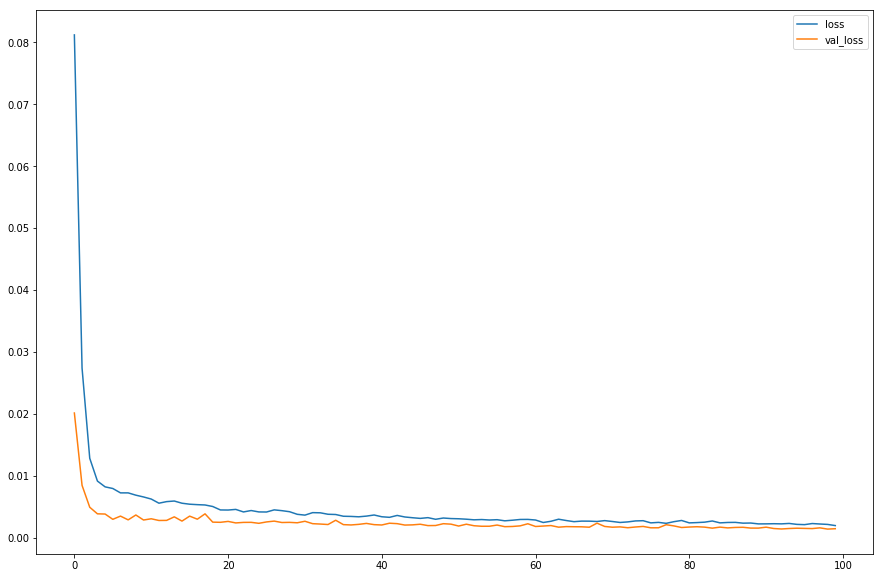

In [0]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [0]:
#Saving the model
file_name = 'Redes/single-company/LSTM_compA_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

NameError: ignored

### Predicting the Test Set to see the results  ( Vamos prever os dados de Teste para o resultado )

In [0]:
Xt = regressor.predict(X_test)

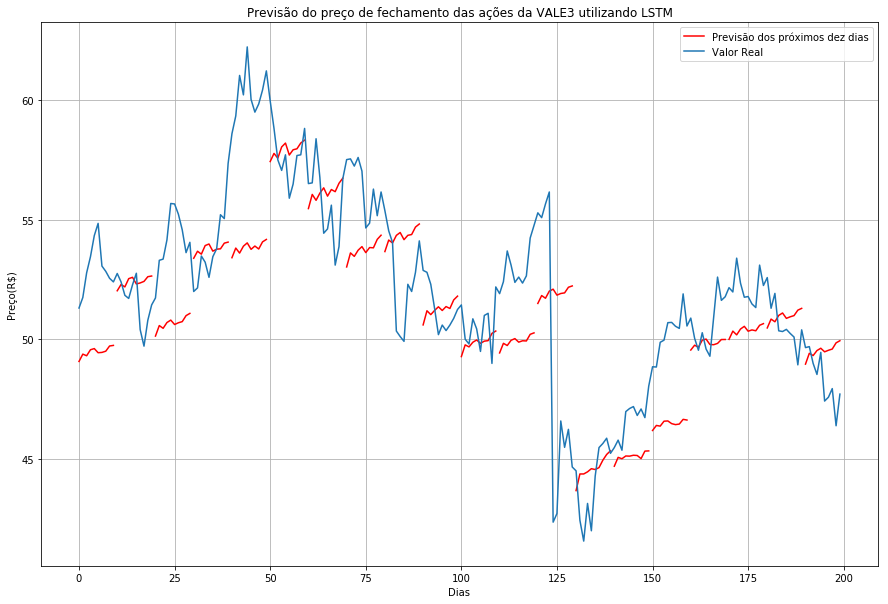

In [0]:
#@title
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.xlabel('Dias')
plt.ylabel('Preço(R$)')
plt.grid(True)
plt.title('Previsão do preço de fechamento das ações da VALE3 utilizando LSTM')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Previsão dos próximos dez dias') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Valor Real')
plt.legend(loc='best')
plt.show()

### Predicting all the data to see how the model reacts to Train and Test set
#### (Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste)

In [0]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [0]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [0]:
Xtrain = regressor.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = regressor.predict(Xtest)
Xtest = Xtest.ravel()

In [0]:
y = np.concatenate((ytrain, ytest), axis=0)

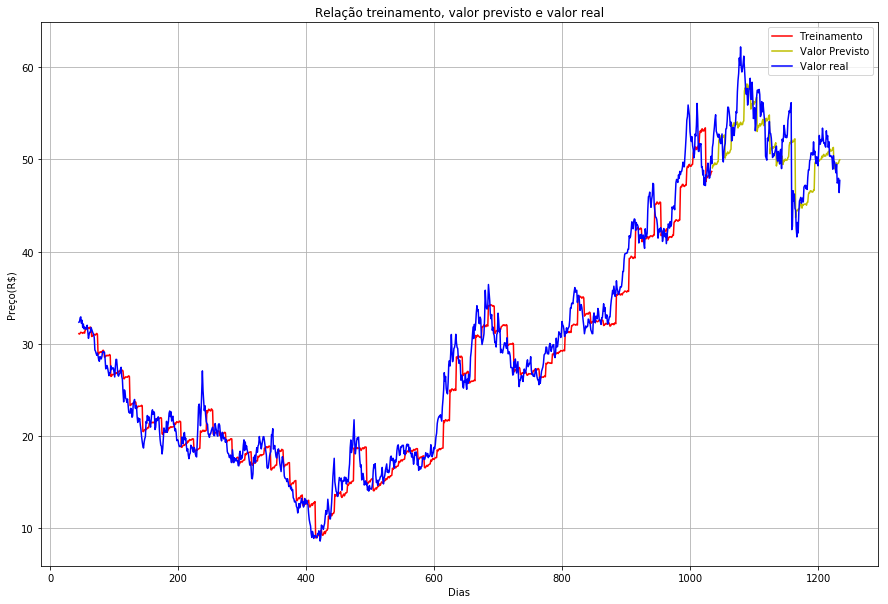

In [0]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Treinamento')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Valor Previsto')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Valor real')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')
plt.xlabel('Dias')
plt.ylabel('Preço(R$)')
plt.grid(True)
plt.title('Relação treinamento, valor previsto e valor real')

plt.legend(loc='best')
plt.show()